<a href="https://colab.research.google.com/github/giveyourselfaTRY/M2A-RLD-TP-PROJET/blob/main/PINN_%E7%AC%AC%E4%B8%80%E9%83%A8%E5%88%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Exercice 1: learning the solution with physics-informed constraints

In PINNs, we want to train a parametric data-driven model $f_{\theta}(x,t)$ to approximate $u(x,t)$ at any (x,t) position. PINNs combine two losses during training:

## Supervised loss

A supervised loss, where we have $N_u$ labeled points $\left\{(x_i,t_i,u_i)\right\}_{i \in \left\{ 1 ; N \right\}}$. We use the standard MSE loss between the model prediction $f_{\theta}(x_i,t_i)$ and the ground truth $u_i$:
$$l_u(\theta) = \frac{1}{N_u} \sum\limits_{i=1}^{N_u} \left[f_{\theta}(x_i,t_i)-u_i(x_i,t_i)\right]^2$$
In the first exercice, we randomly sample $N_u=100$ points **in the boundary layer** - $(x_{min},t)$, $(x_{max},t)$ and in initial condtions $(x,0)$.

## Unsupervised loss

For the unsupervised loss, we randomly sample $N_f$ points in the $(x,t)$ interval, and enforce the learned function $f_{\theta}$ to fulfill the PDE. Let us define
$$h(f_{\theta}(x,t)) = \frac{\partial f_{\theta}(x,t)}{\partial t} + f_{\theta}(x,t) \frac{\partial f_{\theta}(x,t)}{\partial x} - \nu \frac{\partial^2 f_{\theta}(x,t)}{\partial x^2}$$
We can define the following unsupervised loss
$$l_f(\theta) = \frac{1}{N_f} \sum\limits_{i=1}^{N_f} \left[h_{\theta}(x_i,t_i)\right]^2 $$

The final loss in PINNs will be a combination of both supervised and unsupervised  losses:

$$
\mathcal{L}(\theta) = \lambda_u l_u(\theta) + \lambda_fl_f(\theta)
$$

## **1.1) Collect labeled data and unlabeled physics-informed constraint data.**

In the code below, you will collect $N_u$ supervised data points and $N_f$ unsupervised ones. It should set the following values:

- `X_u_train` is a matrix $N_u \times 2$ (dimensions = $x$ and $t$)
- `u_train` is a vector with $u(x,t)$ values for $(x,t)$ couples in `X_u_train`
- `X_f_train` is a matrix $N_f \times 2$ (dimensions = $x$ and $t$)

In [ ]:
# Creates a grid from x and t, of shape (time x position)
T, X = torch.meshgrid(t, x)

assert len(X) == len(t)
assert Exact.shape == T.shape, f"{Exact.shape} vs {T.shape}"

# Shape (N, 2)
X_star = torch.hstack((X.flatten().reshape(-1, 1), T.flatten().reshape(-1, 1)))

# u(x,t) for X_star
u_star = Exact.flatten()

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
X_star.shape

torch.Size([25600, 2])

In [ ]:
###### Labeled points

N_u = 100  # Number of points to compute the prediction loss (MSE_u)

# À compléter...

boundary_mask = (
    (X_star[:, 1] == t.min()) |  # 初始条件 t=0
    (X_star[:, 0] == x.min()) |  # 边界条件 x=x_min
    (X_star[:, 0] == x.max())    # 边界条件 x=x_max
)

# 从满足边界条件的点中随机采样 N_u 个点
boundary_points = X_star[boundary_mask]
idx = torch.randperm(boundary_points.shape[0])[:N_u]
X_u_train = boundary_points[idx]  # shape (N_u, 2)
x_train, t_train = X_u_train.split(1, dim=1)
u_train=u_star[boundary_mask][idx].reshape(-1,1)

# Some checks...

assert x_train.shape == (N_u, 1), f"{x_train.shape} != {(N_u, 1)}"
assert t_train.shape == (N_u, 1), f"{t_train.shape} != {(N_u, 1)}"
assert u_train.shape == (N_u, 1), f"{u_train.shape} != {(N_u, 1)}"
assert (
    (t_train == 0) | (x_train == float(x.min())) | (x_train == float(x.max()))
).all(), "Some points do not belong to boundary"

In [ ]:
###### Unlabeled points

N_f = 10000  # Number of points to apply the constraint

# À compléter...
# assert False, 'Code non implémenté'
idx_f = torch.randperm(X_star.shape[0])[:N_f]
X_f_train = X_star[idx_f]
x_train_f, t_train_f = X_f_train.split(1, dim=1)



# Some checks...

assert x_train_f.shape == (N_f, 1), f"{x_train_f.shape} != {(N_f, 1)}"
assert t_train_f.shape == (N_f, 1), f"{t_train_f.shape} != {(N_f, 1)}"
assert ((x_train_f >= x.min()) & (x_train_f <= x.max())).all()
assert ((t_train_f >= t.min()) & (t_train_f <= t.max())).all()


# Adds boundary points to the unsupervised data set
x_train_f = torch.vstack((x_train_f, x_train))
t_train_f = torch.vstack((t_train_f, t_train))

In [ ]:
# Let's move everything to the target device


def prepare(*tensors):
    return (torch.Tensor(t).float().to(device) for t in tensors)


# Supervised data
x_train, t_train, u_train = prepare(x_train, t_train, u_train)

# Unsupervised data
x_train_f, t_train_f = prepare(x_train_f, t_train_f)

# All data points (for plots)
x_star, t_star = prepare(*X_star.split((1, 1), dim=1))

## 1.2) Plot the selected labeled boundary and initial points.

We can now plot the selected points

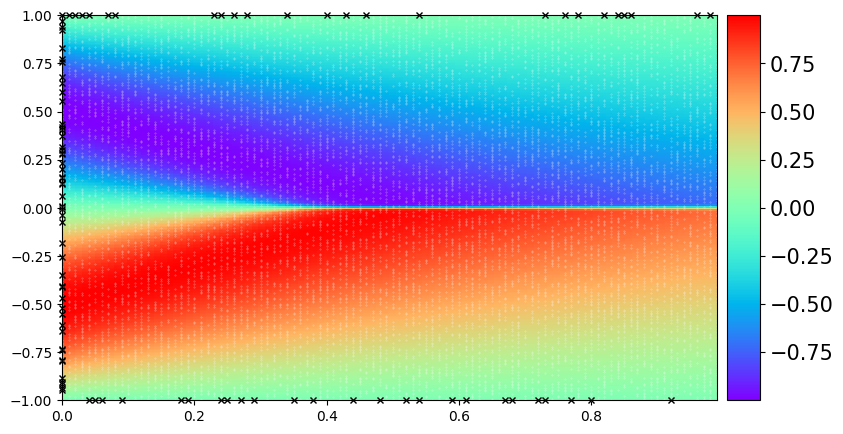

In [ ]:
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(
    Exact.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)

# h = ax.imshow(Exact.T, cmap='rainbow', origin='lower', aspect='auto') # Exact.T size (256,100), u(x,t) avec x[0] = -1
# plt.imshow(Exact.T[::-1,:], cmap='rainbow') # Pour avoir x = -1 en bas

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_train.cpu(),
    x_train.cpu(),
    "kx",
    label="Data (%d points)" % (u_train.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

ax.plot(
    t_train_f.cpu(),
    x_train_f.cpu(),
    "wx",
    markersize=1,  # marker size doubled
    clip_on=False,
    alpha=0.2,
)

plt.show()

## 1.3) Write the code of for $f_\theta$

We will use a simple fully connected neural network (NN) as $f_{\theta}$.
Use *e.g.* 8 hidden layers with tanh activation functions.



In [ ]:
class DNN(torch.nn.Module):
    # À compléter...
    # assert False, 'Code non implémenté'
    def __init__(self, layers):
        super(DNN,self).__init__()
        self.layers = torch.nn.ModuleList()
        for i in range(len(layers)-1):
          self.layers.append(torch.nn.Linear(layers[i],layers[i+1]))
          if i < len(layers)-2:
            self.layers.append(torch.nn.Tanh())
    def forward(self, x,t):
        inputs=torch.hstack((x,t))
        for layer in self.layers:
          inputs = layer(inputs)
        return inputs
    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u = self(x, t)
            u = u.detach().cpu().numpy()
            return u

layers= [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]


dnn = DNN(layers)


dnn.to(device)
assert dnn(x_train[:5], t_train[:5]).shape == (
    5,
    1,
), f"{dnn(x_train[5:], t_train[5:]).shape}"

In [ ]:
print(dnn)

DNN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Tanh()
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Tanh()
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=20, bias=True)
    (11): Tanh()
    (12): Linear(in_features=20, out_features=20, bias=True)
    (13): Tanh()
    (14): Linear(in_features=20, out_features=20, bias=True)
    (15): Tanh()
    (16): Linear(in_features=20, out_features=1, bias=True)
  )
)



## 1.4) Write the code of the PhysicsInformedNN.

We will now implement the core class of this practical: the `PhysicsInformedNN`.

It will be predict the fonction $f_{\theta}(x,t)$, and the $h(f_{\theta}(x,t))$, where the latter is defined as:

$$h(f_{\theta}(x,t)) = \frac{\partial f_{\theta}(x,t)}{\partial t} + f_{\theta}(x,t) \frac{\partial f_{\theta}(x,t)}{\partial x} - \nu \frac{\partial^2 f_{\theta}(x,t)}{\partial x^2}$$

Note that you need to use [`torch.autograd.grad`](https://pytorch.org/docs/stable/generated/torch.autograd.grad.html) to compute derivatives and second order derivatives.

The `forward` function will return both $f_{\theta}(x,t)$ and $h(f_{\theta}(x,t))$.


In [ ]:
# the physics-guided neural network
class PhysicsInformedNN(torch.nn.Module):
    def __init__(self, dnn: DNN, nu: float):
        super().__init__()

        # nu = viscosity
        self.nu = nu
        self.dnn = DNN(layers)



    def forward(self, x: torch.Tensor, t: torch.Tensor):
        # À compléter...
        # assert False, 'Code non implémenté'

        x.requires_grad = True
        t.requires_grad = True
        u = self.dnn(x,t)
        grad_u_t=torch.autograd.grad(u,t,torch.ones_like(u),create_graph=True)[0]
        grad_u_x=torch.autograd.grad(u,x,torch.ones_like(u),create_graph=True)[0]
        grad_u_xx=torch.autograd.grad(grad_u_x,x,torch.ones_like(grad_u_x),create_graph=True)[0]
        f=grad_u_t+u*grad_u_x-self.nu*grad_u_xx
        return u,f

    @contextmanager
    def eval_mode(self):
        training = self.training
        if training:
            self.eval()
        yield
        if training:
            self.train()

    def predict(self, x: torch.Tensor, t: torch.Tensor):
        with self.eval_mode():
            u, f = self(x, t)
            u = u.detach().cpu().numpy()
            f = f.detach().cpu().numpy()
            return u, f


model = PhysicsInformedNN(dnn, 0.01 / np.pi).to(device)

u, f = model(x_train[:5], t_train[:5])
assert u.shape == (5, 1) and f.shape == (5, 1)

## 1.5) Write the code of the pinns_loss to train the PhysicsInformedNN

The `pinss_loss` function should return

- The global loss $\lambda_u L_u + \lambda_f L_f$
- The supervised loss $l_u(\theta) = \frac{1}{N_u} \sum\limits_{i=1}^{N_u} \left[f_{\theta}(x_i,t_i)-u_i(x_i,t_i)\right]^2$
- The unsupervised loss $l_f(\theta) = \frac{1}{N_f} \sum\limits_{i=1}^{N_f} \left[h_{\theta}(x_i,t_i)\right]^2 $

The final loss in PINNs will be a combination of both supervised and unsupervised  losses:

$$
\mathcal{L}(\theta) = \lambda_u l_u(\theta) + \lambda_fl_f(\theta)
$$


In [ ]:
def pinns_loss(
    u_pred: torch.Tensor,
    u_target: torch.Tensor,
    f_pred: torch.Tensor,
    lambda_u=1.0,
    lambda_f=1.0,
):
    # À compléter...
    loss_u=torch.mean((u_pred-u_target)**2)
    loss_f=torch.mean(f_pred**2)
    loss=lambda_u*loss_u+lambda_f*loss_f

    return loss, loss_u, loss_f

## **1.6) Train the model!**

You can use a standard Adam optimizer, or to speed-up convergence a LBFGS. In case of LBFGS, you need to use a closure when calling the step method. This closure will do the forward, and optionally the forward pass:

```python
def loss_closure():
  if torch.is_grad_enabled():
    optimizer.zero_grad()

  loss = ...

  if loss.requires_grad:
    loss.backward()

  return loss

optimizer.step(loss_closure)
```

This closure can be used also when using `Adam` or any other optimizer.


In [ ]:
# À compléter...
model = PhysicsInformedNN(dnn, 0.01 / np.pi).to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)
lambda_u=1.0
lambda_f=1.0

def loss_closure():
  if torch.is_grad_enabled():
    optimizer.zero_grad()

  u_pred,f_pred=model(x_train,t_train)[0],model(x_train_f,t_train_f)[1]
  loss,loss_u,loss_f=pinns_loss(u_pred,u_train,f_pred,lambda_u,lambda_f)

  if loss.requires_grad:
    loss.backward()
  return loss

num_epochs = 1000 # 训练轮数
print_every = 50 # 每隔多少轮打印一次损失

for epoch in range(1, num_epochs + 1):
    # 调用 closure 计算损失并更新参数
    loss = loss_closure()  # 计算当前损失
    optimizer.step(loss_closure)  # 参数更新

    # 打印损失
    if epoch % print_every == 0 or epoch == 1:
        print(f"Epoch {epoch}/{num_epochs} - Loss: {loss.item():.4e}")



Epoch 1/1000 - Loss: 2.4870e-01
Epoch 50/1000 - Loss: 1.8963e-01
Epoch 100/1000 - Loss: 1.3502e-01
Epoch 150/1000 - Loss: 9.1961e-02
Epoch 200/1000 - Loss: 8.1676e-02
Epoch 250/1000 - Loss: 7.5946e-02
Epoch 300/1000 - Loss: 7.0595e-02
Epoch 350/1000 - Loss: 6.2844e-02
Epoch 400/1000 - Loss: 5.7399e-02
Epoch 450/1000 - Loss: 4.9917e-02
Epoch 500/1000 - Loss: 3.9461e-02
Epoch 550/1000 - Loss: 3.5298e-02
Epoch 600/1000 - Loss: 2.7002e-02
Epoch 650/1000 - Loss: 2.4562e-02
Epoch 700/1000 - Loss: 2.2070e-02
Epoch 750/1000 - Loss: 2.0299e-02
Epoch 800/1000 - Loss: 1.8776e-02
Epoch 850/1000 - Loss: 1.7963e-02
Epoch 900/1000 - Loss: 1.6523e-02
Epoch 950/1000 - Loss: 1.5466e-02
Epoch 1000/1000 - Loss: 1.4856e-02


In [ ]:
optimizer=torch.optim.LBFGS(model.parameters(),lr=1.0,max_iter=1000, tolerance_grad=1e-7)
num_epochs = 1 # 训练轮数
# print_every = 100 # 每隔多少轮打印一次损失

for epoch in range(1, num_epochs + 1):
    # 调用 closure 计算损失并更新参数
    loss = loss_closure()  # 计算当前损失
    optimizer.step(loss_closure)  # 参数更新

    # 打印损失
    # if epoch % print_every == 0 or epoch == 1:
    print(f"Epoch {epoch}/{num_epochs} - Loss: {loss.item():.4e}")


Epoch 1/1 - Loss: 1.4901e-02


## **1.7) Asses the performances of the model!**

- Visually assess the prediction on the  $(x,t)$ plane
- Compute the mean prediction error, and the error in the $(x,t)$ plane
- the prediction error over time slices at $t=0$, $t=25$, $t=50$, $t=75$

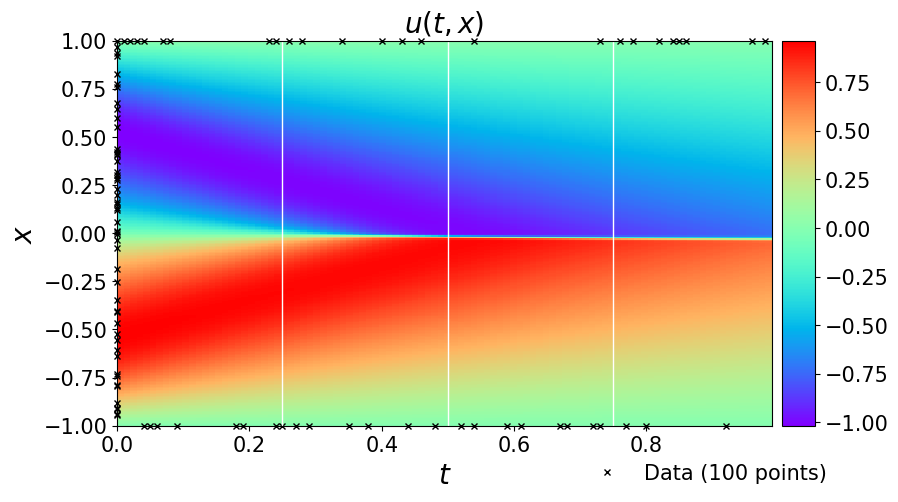

In [ ]:
####### Visually assess the prediction on the  $(x,t)$ plane

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

u_pred, f_pred = model.predict(x_star, t_star)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method="cubic")

h = ax.imshow(
    U_pred.T,
    interpolation="nearest",
    cmap="rainbow",
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15)

ax.plot(
    t_train.cpu().detach().numpy(),
    x_train.cpu().detach().numpy(),
    "kx",
    label="Data (%d points)" % (u_train.shape[0]),
    markersize=4,  # marker size doubled
    clip_on=False,
    alpha=1.0,
)

line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[25] * np.ones((2, 1)), line, "w-", linewidth=1)
ax.plot(t[50] * np.ones((2, 1)), line, "w-", linewidth=1)
ax.plot(t[75] * np.ones((2, 1)), line, "w-", linewidth=1)

ax.set_xlabel("$t$", size=20)
ax.set_ylabel("$x$", size=20)
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.9, -0.05),
    ncol=5,
    frameon=False,
    prop={"size": 15},
)
ax.set_title("$u(t,x)$", fontsize=20)  # font size doubled
ax.tick_params(labelsize=15)

plt.show()

Error u: 1.838620e-01


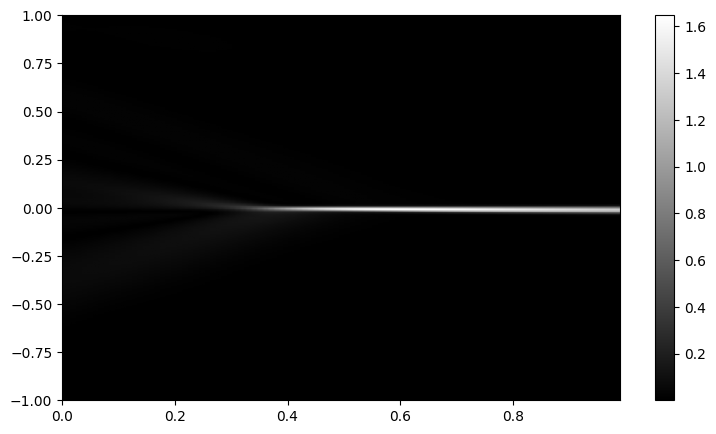

In [ ]:
####### Compute the mean prediction error
error_u = np.linalg.norm(u_star - u_pred.flatten(), 2) / np.linalg.norm(u_star, 2)
print("Error u: %e" % (error_u))

# U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = np.abs(Exact - U_pred)

####### Error in the $(x,t)$ planefig = plt.figure(figsize=(9, 5))
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(Error.T, extent=extent, origin="lower", aspect="auto", cmap="gray")
cbar = fig.colorbar(h)
plt.show()

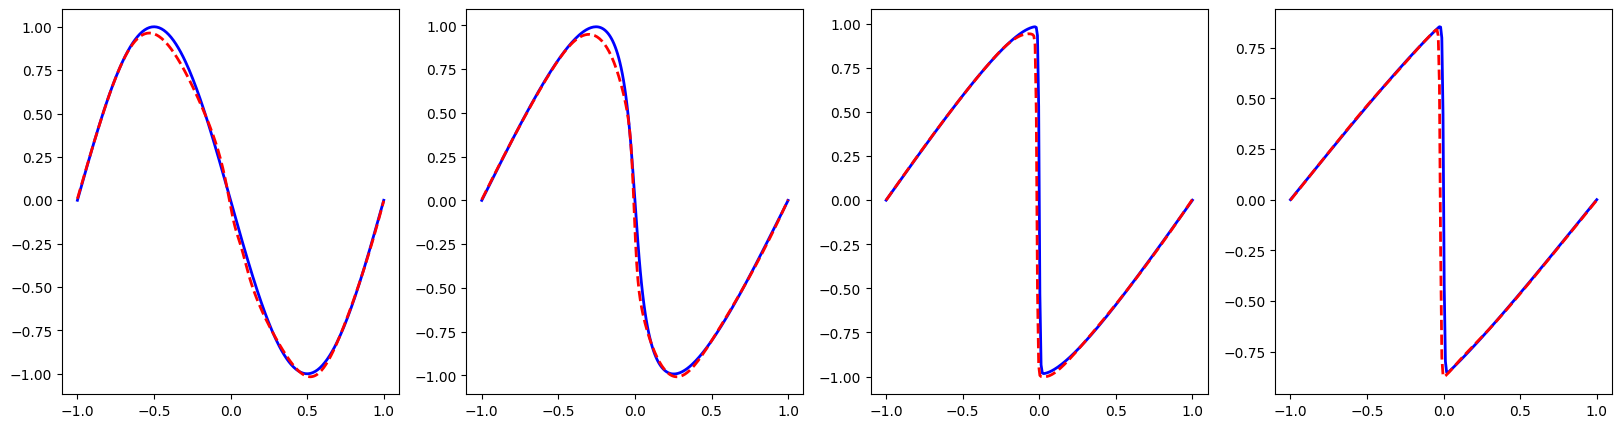

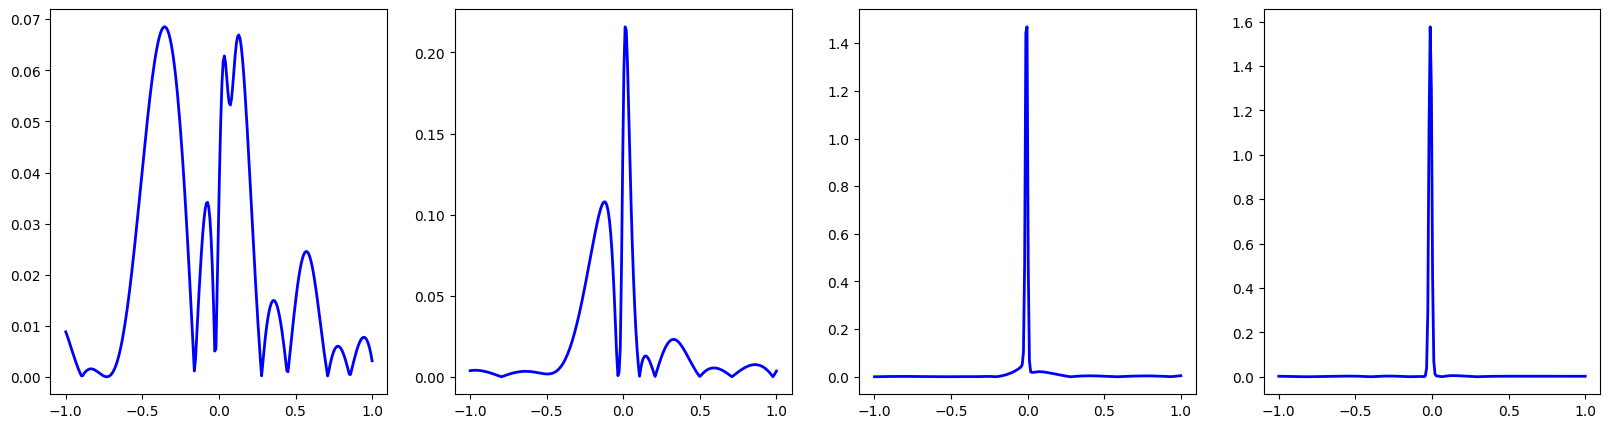

In [ ]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Exact[0, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[0, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(142)
ax.plot(x, Exact[25, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[25, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(143)
ax.plot(x, Exact[50, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[50, :], "r--", linewidth=2, label="Prediction")


ax = fig.add_subplot(144)
ax.plot(x, Exact[75, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[75, :], "r--", linewidth=2, label="Prediction")

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Error[0, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(142)
ax.plot(x, Error[25, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(143)
ax.plot(x, Error[50, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(144)
ax.plot(x, Error[75, :], "b-", linewidth=2, label="Erreur")

# print(Error[75,100:150])

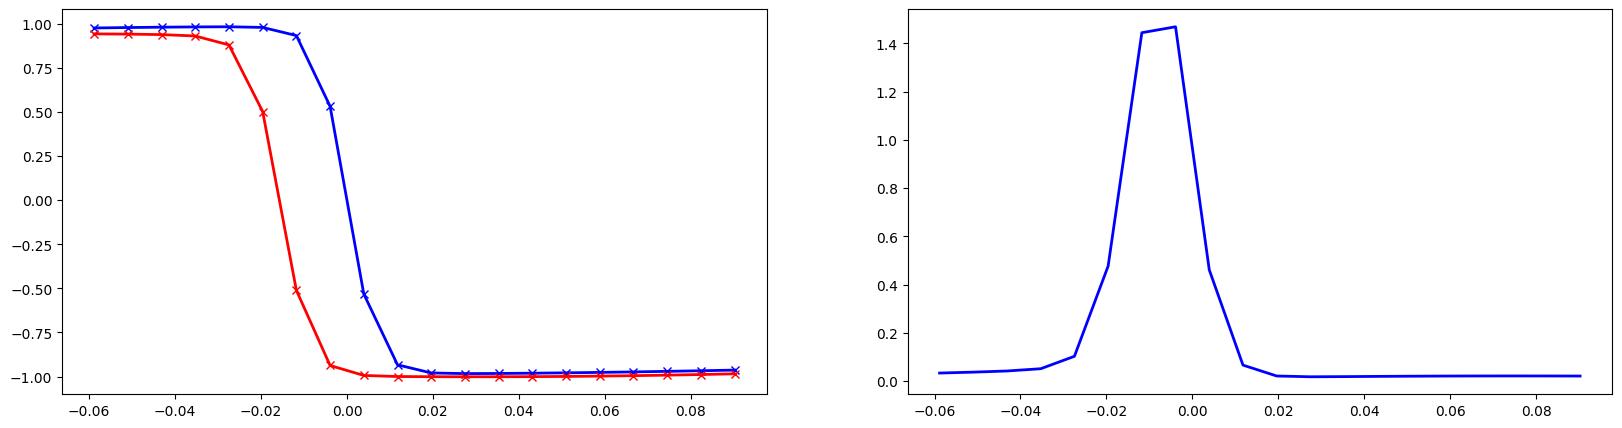

In [ ]:
############# Close-up on slide at t=50
index = 50
min = 120
max = 140
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(121)
ax.plot(x[min:max], Exact[index, min:max], "b-x", linewidth=2, label="Exact")
ax.plot(x[min:max], U_pred[index, min:max], "r-x", linewidth=2, label="Prediction")

ax = fig.add_subplot(122)
ax.plot(x[min:max], Error[index, min:max], "b-", linewidth=2, label="Exact")

## **1.8) Train a prediction model without adding any constraint (fully data-driven model). Conclude.**

### **1.8: 完全数据驱动模型的训练方式**

在 **1.8** 中，模型的训练仅依赖于有标签的数据点，完全忽略了物理约束。这种方式等价于标准的监督学习，使用的数据点通常是从整个 \( (x, t) \) 空间中采样的。

**损失函数**：
- 只包含监督损失：
  $$
  l_u(\theta) = \frac{1}{N_u} \sum_{i=1}^{N_u} \left[f_\theta(x_i, t_i) - u_i\right]^2
  $$

**训练方式**：
- 仅利用有限的有标签数据点，模型拟合这些数据点，但无法利用物理规律来指导无标签区域的学习。

In [ ]:
# À compléter...
dnn=DNN(layers).to(device)
optimizer=torch.optim.LBFGS(dnn.parameters(),lr=1.0,max_iter=1000, tolerance_grad=1e-7)
def loss_closure():
    """
    计算监督损失并返回
    """
    if torch.is_grad_enabled():
        optimizer.zero_grad()  # 清零梯度

    # 使用有标签数据点计算预测值和损失
    u_pred = dnn(x_train, t_train)
    loss = torch.mean((u_pred - u_train) ** 2)  # 监督损失：均方误差

    # 反向传播
    if loss.requires_grad:
        loss.backward()

    return loss

# # 开始训练
num_epochs = 1 # L-BFGS 通常一次性完成优化

for epoch in range(1, num_epochs + 1):
    # 调用 closure 计算损失并更新参数
    loss = loss_closure()  # 计算当前损失
    optimizer.step(loss_closure)  # 参数更新

    # 打印损失
    # if epoch % print_every == 0 or epoch == 1:
    print(f"Epoch {epoch}/{num_epochs} - Loss: {loss.item():.4e}")



Epoch 1/1 - Loss: 2.3819e-01


Error u: 6.387916e-01


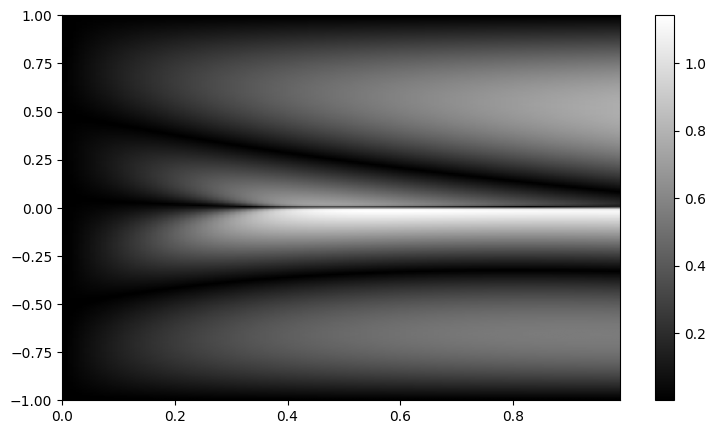

In [ ]:
####### Compute the mean prediction error
u_pred = dnn.predict(x_star, t_star)

error_u = np.linalg.norm(u_star - u_pred.flatten(), 2) / np.linalg.norm(u_star, 2)
print("Error u: %e" % (error_u))


U_pred = griddata(X_star, u_pred.flatten(), (X, T), method="cubic")
Error = np.abs(Exact - U_pred)

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)
h = ax.imshow(
    Error.T,
    extent=[t.min(), t.max(), x.min(), x.max()],
    origin="lower",
    aspect="auto",
    cmap="gray",
)
cbar = fig.colorbar(h)
plt.show()

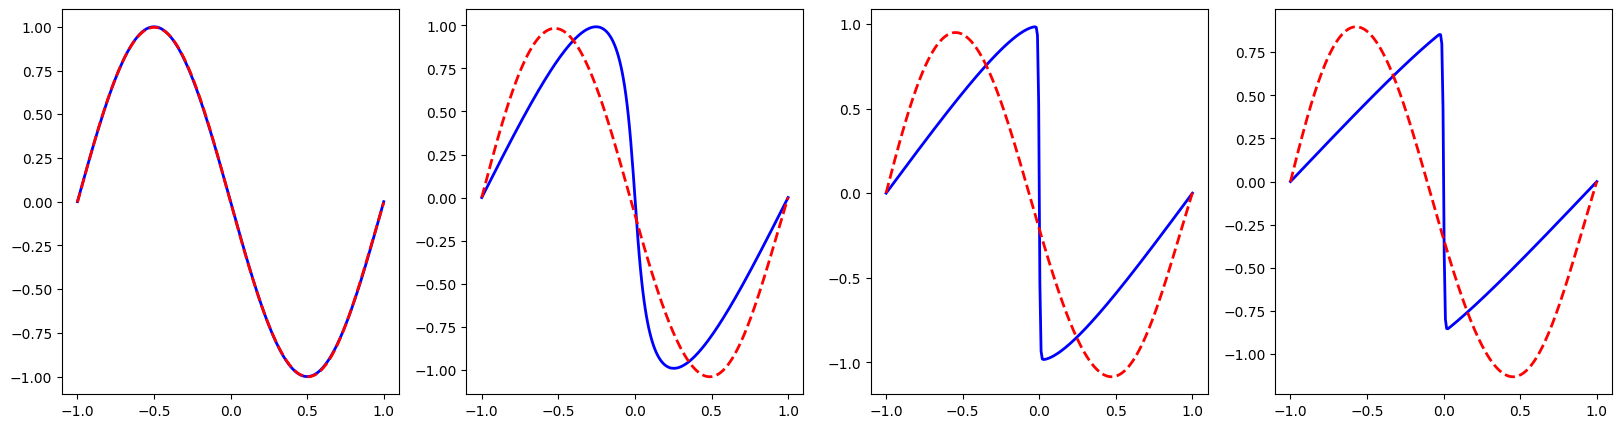

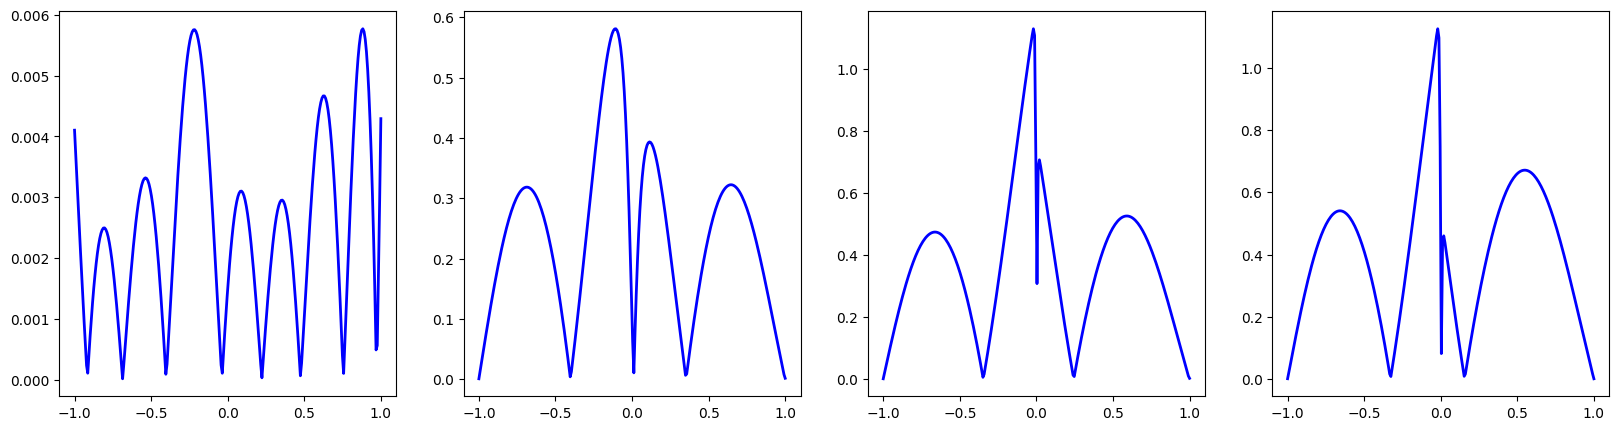

In [ ]:
fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Exact[0, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[0, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(142)
ax.plot(x, Exact[25, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[25, :], "r--", linewidth=2, label="Prediction")

ax = fig.add_subplot(143)
ax.plot(x, Exact[50, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[50, :], "r--", linewidth=2, label="Prediction")


ax = fig.add_subplot(144)
ax.plot(x, Exact[75, :], "b-", linewidth=2, label="Exact")
ax.plot(x, U_pred[75, :], "r--", linewidth=2, label="Prediction")

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(141)
ax.plot(x, Error[0, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(142)
ax.plot(x, Error[25, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(143)
ax.plot(x, Error[50, :], "b-", linewidth=2, label="Erreur")

ax = fig.add_subplot(144)
ax.plot(x, Error[75, :], "b-", linewidth=2, label="Erreur")